# EIA Energy Demand Data
https://www.eia.gov/opendata/

The United States Energy Information Agency (EIA) provides open access to hundreds of thousands of time series datasets via a REST API. The data is in the public domain, but does require [registraton and an API key](https://www.eia.gov/opendata/register.php).

In this notebook I'll explore the data source by extracting historical energy demand via API call. 

In [1]:
import requests
import os
from dotenv import load_dotenv
from pprint import pprint
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import calendar
from pprint import pprint
plt.style.use('fivethirtyeight')

load_dotenv()
EIA_KEY = os.getenv('EIA_KEY')

Hourly energy demand for the Public Service Company of Colorado in UTC time has the series ID `EBA.PSCO-ALL.D.H`. I can use the `requests` library to pull the data.

In [2]:
url = 'https://api.eia.gov/series/'
series_id = 'EBA.PSCO-ALL.D.H'

params = {'api_key': EIA_KEY,
          'series_id': series_id,
          'start': '2019'}

r = requests.get(url, params)
r

<Response [200]>

The response comes in JSON format, and looks like this:

In [3]:
j = (str(r.json()))
pprint(j[:1000])

("{'request': {'command': 'series', 'series_id': 'EBA.PSCO-ALL.D.H'}, "
 "'series': [{'series_id': 'EBA.PSCO-ALL.D.H', 'name': 'Demand for Public "
 "Service Company of Colorado (PSCO), hourly - UTC time', 'units': "
 "'megawatthours', 'f': 'H', 'description': 'Timestamps follow the ISO8601 "
 'standard (https://en.wikipedia.org/wiki/ISO_8601). Hourly representations '
 "are provided in Universal Time.', 'start': '20150701T07Z', 'end': "
 "'20220314T00Z', 'updated': '2022-03-13T20:48:01-0400', 'data': "
 "[['20220314T00Z', 5496], ['20220313T23Z', 5200], ['20220313T22Z', 4980], "
 "['20220313T21Z', 4741], ['20220313T20Z', 4701], ['20220313T19Z', 4765], "
 "['20220313T18Z', 4811], ['20220313T17Z', 4882], ['20220313T16Z', 4984], "
 "['20220313T15Z', 5104], ['20220313T14Z', 5181], ['20220313T13Z', 5138], "
 "['20220313T12Z', 4964], ['20220313T11Z', 4853], ['20220313T10Z', 4797], "
 "['20220313T09Z', 4832], ['20220313T08Z', 4866], ['20220313T07Z', 4869], "
 "['20220313T06Z', 5148], ['202203

To extract the actual data series, we will need to parse the JSON into a dataframe.

In [4]:
for series in r.json()['series']:
    data=series['data']
    series_id=series['series_id']

In [5]:
mountain = pytz.timezone('US/Mountain')

df = (pd.DataFrame(data, columns=['timestamp', series_id])
        .assign(timestamp=lambda df_:pd.to_datetime(df_['timestamp']))
        .set_index('timestamp')
     )

df.index = df.index.tz_convert(mountain)


Below are some analysis into the different levels of cyclicly in the data.

Seasonal: during the cold parts of the winter, and the hot parts of the summer, there is higher demand than in the spring and fall.

<AxesSubplot:xlabel='timestamp'>

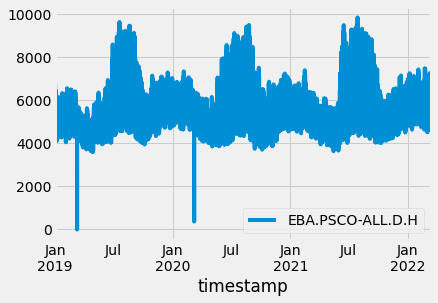

In [6]:
df.plot()

The same pattern is a little more clear if we plot the daily sum of energy demand.

<AxesSubplot:xlabel='timestamp'>

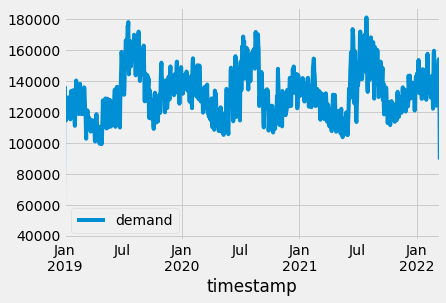

In [7]:
daily = df.resample('d').sum()
daily['demand'] = daily.sum(axis=1)
daily = daily[['demand']]
daily.plot()

There is a clear weekly cycle with more energy being used on the weekdays than on the weekends.

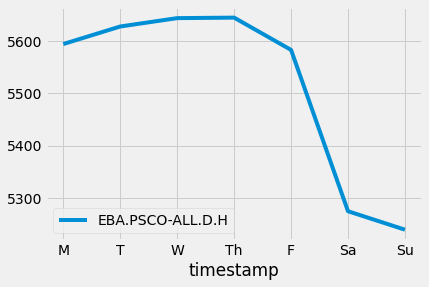

In [8]:
ax = df.groupby(df.index.dayofweek).mean().plot()
ax.set_xticks(range(0,7))
ax.set_xticklabels(['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']);

In [9]:
weekdays_only = df[df.index.dayofweek < 5]
hourly = (weekdays_only            
            .groupby([weekdays_only.index.hour, weekdays_only.index.month])
            .mean()
            .unstack()
        )
hourly.columns = hourly.columns.droplevel()
hourly.columns = calendar.month_abbr[1:]

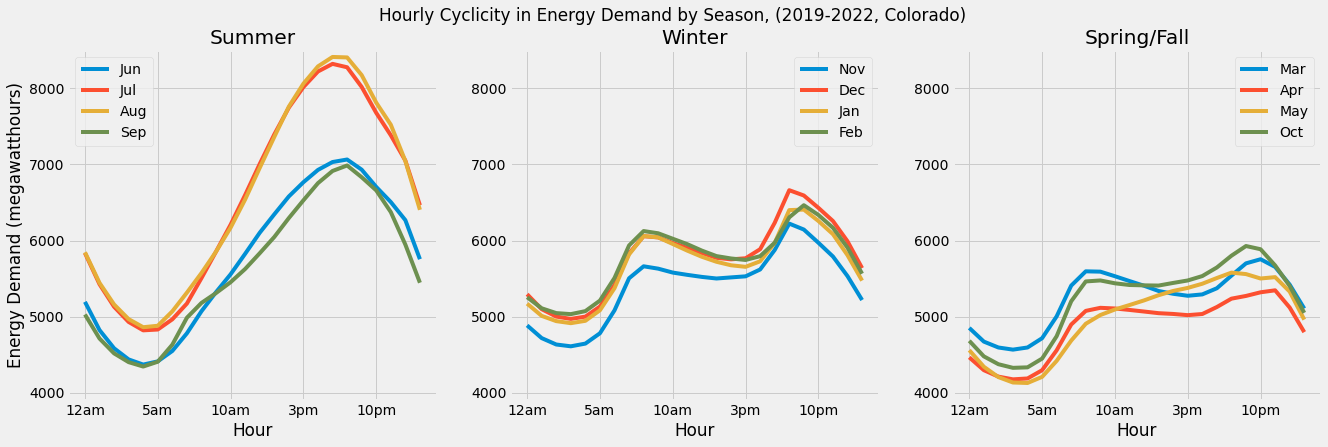

In [10]:

fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
hourly[['Jun', 'Jul', 'Aug', 'Sep']].plot(ax=ax[0])
hourly[['Nov', 'Dec', 'Jan', 'Feb']].plot(ax=ax[1])
hourly[['Mar', 'Apr', 'May', 'Oct']].plot(ax=ax[2])

fig.suptitle('Hourly Cyclicity in Energy Demand by Season, (2019-2022, Colorado)')

ax[0].set_title('Summer')
ax[0].set_ylabel('Energy Demand (megawatthours)')

ax[1].set_title('Winter')
ax[2].set_title('Spring/Fall')
for a in ax:
    a.set_ylim((3900, 8500))
    a.set_xlabel('Hour')

    a.set_xticks([0, 5, 10, 15, 20])
    a.set_xticklabels(['12am', '5am', '10am', '3pm', '10pm']);



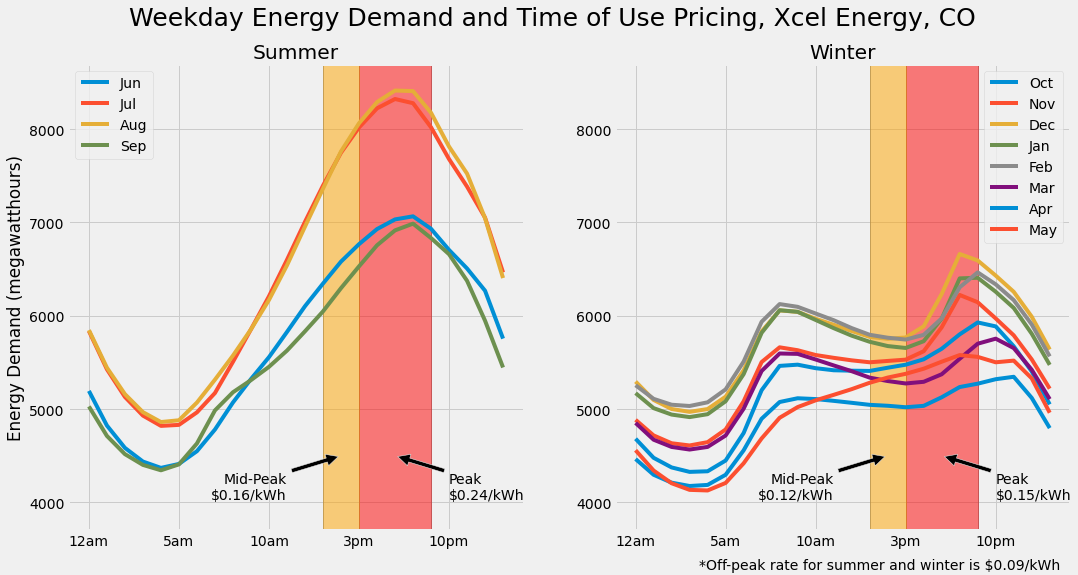

In [11]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))


fig.suptitle('Weekday Energy Demand and Time of Use Pricing, Xcel Energy, CO', fontsize=25)
ax[0].set_title('Summer')
ax[0].set_ylabel('Energy Demand (megawatthours)')
ax[1].set_title('Winter')

hourly[['Jun', 'Jul', 'Aug', 'Sep']].plot(ax=ax[0])
hourly[['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May',]].plot(ax=ax[1])

for a in ax:
    a.set_ylim((3700, 8700))
    a.set_xlabel('Hour')
    
    a.axvline(13, color='grey', linewidth=.75, zorder=1)
    a.axvline(15, color='grey', linewidth=.75, zorder=1)
    a.axvline(19, color='grey', linewidth=.75, zorder=1)
    
    a.axvspan(xmin=15, xmax=19, alpha=.5, color='red')
    a.axvspan(xmin=13, xmax=15, alpha=.5, color='orange')

    a.set_xticks([0, 5, 10, 15, 20])
    a.set_xticklabels(['12am', '5am', '10am', '3pm', '10pm'])
    a.set_xlabel('')
    


ax[0].annotate('Mid-Peak\n$0.16/kWh', xy=(14, 4500),  xycoords='data',
            xytext=(11, 4000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',
            )

ax[0].annotate('Peak\n$0.24/kWh', xy=(17, 4500),  xycoords='data',
            xytext=(20, 4000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            )

ax[1].annotate('Mid-Peak\n$0.12/kWh', xy=(14, 4500),  xycoords='data',
            xytext=(11, 4000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='bottom',
            )

ax[1].annotate('Peak\n$0.15/kWh', xy=(17, 4500),  xycoords='data',
            xytext=(20, 4000), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='bottom',
            )

ax[0].annotate('*Off-peak rate for summer and winter is $0.09/kWh', xy=(.92, .005),
               xycoords='figure fraction',
               horizontalalignment='right',
               verticalalignment='bottom');